# BQL Examples Notebook

A collection of short examples demonstrating how to use `bql()` from the `polars_bloomberg` library. All data and code snippets are self-contained.  
Scroll down or use the table of contents to explore different usage scenarios.

## Table of Contents
- [ 1. Basic Usage - Single Security, Single Data Item](#section-1)
- [ 2: Basic Usage - Multiple Securities, Single Data Item](#section-2)
- [ 3: More Complex Example - Multiple Data Items](#section-3)
- [ 4: Screening Securities](#section-4)
- [ 5: Aggregation: Average P/E per Sector](#section-5)
- [ 6: Binning: Average OAS per Maturity Bucket](#section-6)
- [ 7: Aggregation: US High Yield Maturity Wall](#section-7)
- [ 8: Stock Technical Analysis Screening](#section-8)
- [ 9: Segments](#section-9)
- [10: AT1 Axes](#section-10)
- [11: RT1 Axes with addcol=ALL](#section-11)
- [12: Bonds from Equity Ticker](#section-12)
- [13: Bond Total Return](#section-13)


In [138]:
#
# Imports and setup
#
import altair as alt
import polars as pl

from polars_bloomberg import BQuery

alt.renderers.enable("svg")  # static charts
pl.Config.set_fmt_str_lengths(30)  # consistent display width for Polars


polars.config.Config

## 1: Basic Usage - Single Security, Single Data Item
<a id="section-1"></a>

In [139]:
# Minimal example querying a single security for one data item
with BQuery() as bq:
    result = bq.bql("get(px_last) for(['IBM US Equity'])")

# Polars DataFrame display
df = result[0]
df  # shows first rows automatically

ID,px_last,DATE,CURRENCY
str,f64,date,str
"""IBM US Equity""",225.119995,2024-12-20,"""USD"""


## 2: Basic Usage - Multiple Securities, Single Data Item
<a id="section-2"></a>

In [140]:
# Querying multiple securities for 'PX_LAST'
with BQuery() as bq:
    result = bq.bql("get(px_last) for(['AAPL US Equity', 'MSFT US Equity'])")

df_multi = result[0]
df_multi

ID,px_last,DATE,CURRENCY
str,f64,date,str
"""AAPL US Equity""",250.660004,2024-12-20,"""USD"""
"""MSFT US Equity""",437.630005,2024-12-20,"""USD"""


## 3: More Complex Example - Multiple Data Items
<a id="section-3"></a>

In [141]:
# Example with multiple data items across several dates
# Note: The data is artificially shortened for demonstration

with BQuery() as bq:
    results = bq.bql("""
        get(px_last, px_volume)
        for(['TLT US Equity', 'SEBA SS Equity'])
    """)

# Combine the two DataFrames
df = results.combine()
df


ID,px_last,DATE,CURRENCY,px_volume
str,f64,date,str,f64
"""TLT US Equity""",88.620102,2024-12-20,"""USD""",1.4092481e7
"""SEBA SS Equity""",148.300003,2024-12-20,"""SEK""",2.544498e6


## 4. Screening Securities
<a id="section-4"></a>

shape: (3, 6)
┌───────────────┬────────────────┬──────────┬────────────┬────────────┬────────┐
│ ID            ┆ name           ┆ #dur     ┆ DATE       ┆ #zsprd     ┆ ticker │
│ ---           ┆ ---            ┆ ---      ┆ ---        ┆ ---        ┆ ---    │
│ str           ┆ str            ┆ f64      ┆ date       ┆ f64        ┆ str    │
╞═══════════════╪════════════════╪══════════╪════════════╪════════════╪════════╡
│ ZL122341 Corp ┆ SWEDA 7 ⅝ PERP ┆ 3.153085 ┆ 2024-12-20 ┆ 261.895417 ┆ SWEDA  │
│ BR069680 Corp ┆ SWEDA 4 PERP   ┆ 4.123301 ┆ 2024-12-20 ┆ 309.223001 ┆ SWEDA  │
│ BR151958 Corp ┆ NDAFH 3 ¾ PERP ┆ 3.701263 ┆ 2024-12-20 ┆ 339.736668 ┆ NDAFH  │
└───────────────┴────────────────┴──────────┴────────────┴────────────┴────────┘


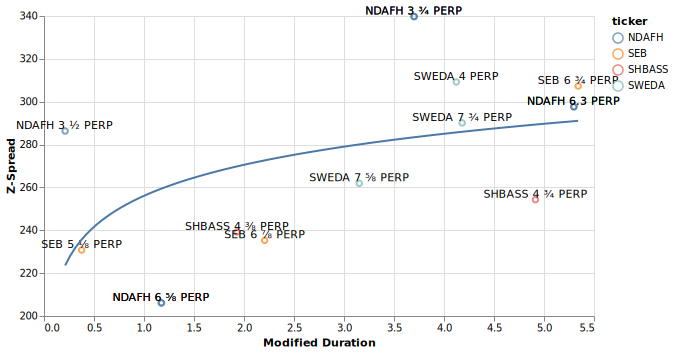

In [142]:
#
# Get all SEB and Handelsbanken's COCO bonds' modified duration and Z-spread
#
query = """
    let(#dur=duration(duration_type=MODIFIED);
        #zsprd=spread(spread_type=Z);)
    get(name, #dur, #zsprd, ticker)
    for(filter(screenresults(type=SRCH, screen_name='@COCO'),
            ticker in ['SEB', 'SHBASS', 'SWEDA', 'NDAFH'] and
            crncy() in ['USD', 'EUR']))
"""

with BQuery() as bq:
    results = bq.bql(query)
combined_df = results.combine()
# print combined_df
print(combined_df.head(3))

# Create chart
base = alt.Chart(combined_df).encode(
    x=alt.X("#dur:Q").title("Modified Duration"),
    y=alt.Y("#zsprd:Q").title("Z-Spread").scale(zero=False),
)
points = base.mark_point().encode(color="ticker")
txt = base.mark_text(align="center", baseline="bottom").encode(text="name")
fit = base.transform_regression("#dur", "#zsprd", method="log").mark_line()
(points + txt + fit).properties(width=550)

## 5. Aggregation: Average PE per Sector
<a id="section-5"></a>

shape: (3, 7)
┌───────────────┬──────────┬───────────────┬────────────┬───────────────┬──────────┬───────────────┐
│ ID            ┆ #avg_pe  ┆ REVISION_DATE ┆ AS_OF_DATE ┆ PERIOD_END_DA ┆ ORIG_IDS ┆ GICS_SECTOR_N │
│ ---           ┆ ---      ┆ ---           ┆ ---        ┆ TE            ┆ ---      ┆ AME()         │
│ str           ┆ f64      ┆ date          ┆ date       ┆ ---           ┆ str      ┆ ---           │
│               ┆          ┆               ┆            ┆ date          ┆          ┆ str           │
╞═══════════════╪══════════╪═══════════════╪════════════╪═══════════════╪══════════╪═══════════════╡
│ Communication ┆ 25.66221 ┆ 2024-11-14    ┆ 2024-12-20 ┆ 2024-09-30    ┆ null     ┆ Communication │
│ Services      ┆          ┆               ┆            ┆               ┆          ┆ Services      │
│ Consumer      ┆ 25.75316 ┆ 2024-12-20    ┆ 2024-12-20 ┆ 2024-11-30    ┆ null     ┆ Consumer      │
│ Discretionary ┆          ┆               ┆            ┆               ┆    

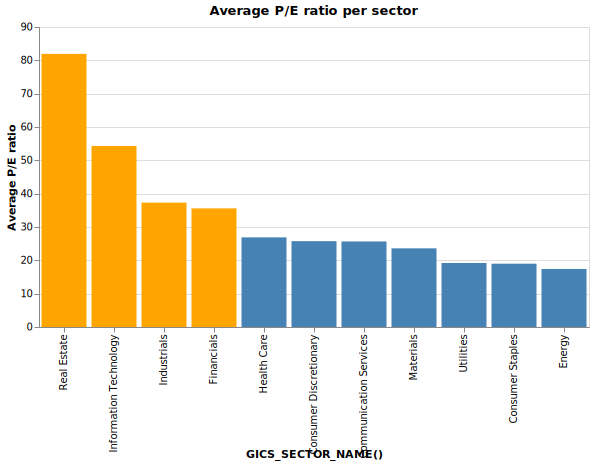

In [143]:
#
# Average PE ratio per sector
#
query = """
let(#avg_pe=avg(group(pe_ratio(), gics_sector_name()));)
get(#avg_pe)
for(members('SPX Index'))
"""
with BQuery() as bq:
    df = bq.bql(query).combine()
print(df.head(3))

# Chart P/E per sector
alt.Chart(df, title="Average P/E ratio per sector").mark_bar().encode(
    x=alt.X("GICS_SECTOR_NAME()").sort("-y"),
    y=alt.Y("#avg_pe:Q").title("Average P/E ratio"),
    color=alt.condition(
        alt.datum["#avg_pe"] > 30,  # noqa: PLR2004
        alt.value("orange"),
        alt.value("steelblue"),
    ),
).properties(width=550)

## 6. Binning: Average Spread per Maturity Bucket
<a id="section-6"></a>

shape: (3, 5)
┌──────────┬─────────────────┬────────────┬───────────────┬──────────┐
│ ID       ┆ #average_spread ┆ DATE       ┆ ORIG_IDS      ┆ #BINS    │
│ ---      ┆ ---             ┆ ---        ┆ ---           ┆ ---      │
│ str      ┆ f64             ┆ date       ┆ str           ┆ str      │
╞══════════╪═════════════════╪════════════╪═══════════════╪══════════╡
│ (1) 0-3  ┆ 32.730478       ┆ 2024-12-20 ┆ QZ552396 Corp ┆ (1) 0-3  │
│ (2) 3-9  ┆ 62.850184       ┆ 2024-12-20 ┆ null          ┆ (2) 3-9  │
│ (3) 9-18 ┆ 111.386605      ┆ 2024-12-20 ┆ BH393780 Corp ┆ (3) 9-18 │
└──────────┴─────────────────┴────────────┴───────────────┴──────────┘


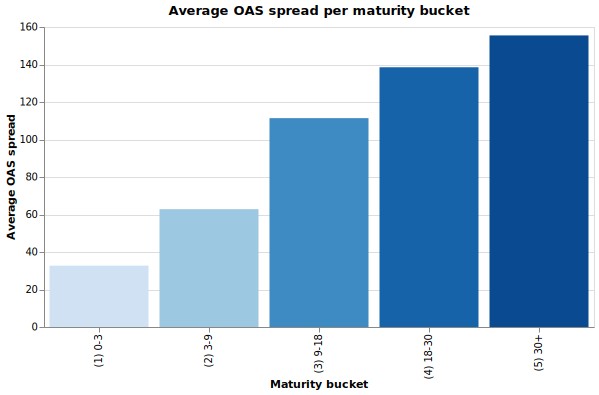

In [144]:
# Average OAS spread for Nvidia bonds per maturity bucket
query = """
let(
    #bins = bins(maturity_years,
                 [3,9,18,30],
                 ['(1) 0-3','(2) 3-9','(3) 9-18','(4) 18-30','(5) 30+']);
    #average_spread = avg(group(spread(st=oas),#bins));
)
get(#average_spread)
for(filter(bonds('NVDA US Equity', issuedby = 'ENTITY'),
           maturity_years != NA))
"""

with BQuery() as bq:
    df = bq.bql(query).combine()
print(df.head(3))

# Chart
alt.Chart(df, title="Average OAS spread per maturity bucket").mark_bar().encode(
    x=alt.X("#BINS").title("Maturity bucket"),
    y=alt.Y("#average_spread:Q").title("Average OAS spread"),
    color=alt.Color("#average_spread:Q").legend(None),
).properties(width=550)

## 7. Aggregation: US High Yield Maturity Wall
<a id="section-7"></a>

shape: (5, 11)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ maturity ┆ Basic     ┆ Consumer, ┆ Energy    ┆ … ┆ Financial ┆ Technolog ┆ Utilities ┆ Diversifi │
│ ---      ┆ Materials ┆ Non-cycli ┆ ---       ┆   ┆ ---       ┆ y         ┆ ---       ┆ ed        │
│ i64      ┆ ---       ┆ cal       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---       │
│          ┆ f64       ┆ ---       ┆           ┆   ┆           ┆ f64       ┆           ┆ f64       │
│          ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2025     ┆ 1.5e8     ┆ 5.34916e8 ┆ 5e8       ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2026     ┆ 4.4013e9  ┆ 9.3293e9  ┆ 8.2931e9  ┆ … ┆ 1.3524e10 ┆ 4.0608e9  ┆ 2.5202e9  ┆ null      │
│ 2027     ┆ 8.3921e9  ┆ 2.3409e10 ┆ 1.2427e10 ┆ … ┆ 1.9430e10 ┆ 4.3367e9  ┆

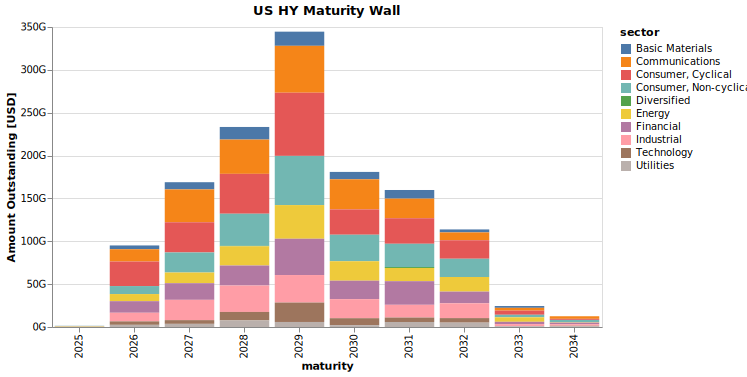

In [145]:
# Maturity Wall for US HY bonds
query = """
let(#mv=sum(group(amt_outstanding(currency=USD),
                  by=[year(maturity()), industry_sector()]));)
get(#mv)
for(members('LF98TRUU Index'))
"""
with BQuery() as bq:
    results = bq.bql(query)
df = results.combine().rename(
    {"YEAR(MATURITY())": "maturity", "INDUSTRY_SECTOR()": "sector", "#mv": "mv"}
)

print(df.pivot(index="maturity", on="sector", values="mv").head())

alt.Chart(
    df.drop_nulls(subset=["maturity"]), title="US HY Maturity Wall"
).mark_bar().encode(
    x=alt.X("maturity:O"),
    y=alt.Y("mv:Q").axis(format="~s").title("Amount Outstanding [USD]"),
    color=alt.Color("sector:N"),
).transform_filter(alt.datum.maturity < 2035).properties(width=550)  # noqa: PLR2004

## 8. Stock Technical Analysis Screening
<a id="section-8"></a>

In [146]:
#
# stocks with 20d EMA above 200d EMA and RSI > 35
#
with BQuery() as bq:
    results = bq.bql(
        """
        let(#ema20=emavg(period=20);
            #ema200=emavg(period=200);
            #rsi=rsi(close=px_last());)
        get(name(), #ema20, #ema200, #rsi)
        for(filter(members('OMX Index'),
                    and(#ema20 > #ema200, #rsi > 35)))
        with(fill=PREV)
        """
    )
results.combine()

ID,name(),#ema20,DATE,CURRENCY,#ema200,#rsi
str,str,f64,date,str,f64,f64
"""SAABB SS Equity""","""Saab AB""",233.149977,2024-12-20,"""SEK""",224.899012,39.102426
"""ALFA SS Equity""","""Alfa Laval AB""",473.930895,2024-12-20,"""SEK""",455.732764,36.334121
"""ERICB SS Equity""","""Telefonaktiebolaget LM Ericsso""",89.946413,2024-12-20,"""SEK""",75.6331,39.078065
"""SKFB SS Equity""","""SKF AB""",213.179386,2024-12-20,"""SEK""",205.293767,38.139358
"""SHBA SS Equity""","""Svenska Handelsbanken AB""",113.654326,2024-12-20,"""SEK""",107.114168,37.41394
"""SWEDA SS Equity""","""Swedbank AB""",216.841524,2024-12-20,"""SEK""",213.662319,38.197084


## 9. Segments
<a id="section-9"></a>
The following example shows handling of two data-items with different length. The first dataframe 
describes the segments (and has length 5 in this case), while the second dataframe contains time series.
One can join the dataframes on common columns and pivot the segments into columns as shown below:

shape: (3, 3)
┌─────────────────┬───────────┬────────────────────────┐
│ PERIOD_END_DATE ┆ Sirius XM ┆ Pandora & Off-Platform │
│ ---             ┆ ---       ┆ ---                    │
│ date            ┆ f64       ┆ f64                    │
╞═════════════════╪═══════════╪════════════════════════╡
│ 2022-09-30      ┆ 1.7420e9  ┆ 5.38e8                 │
│ 2022-12-31      ┆ 1.7230e9  ┆ 5.6e8                  │
│ 2023-03-31      ┆ 1.6820e9  ┆ 4.62e8                 │
└─────────────────┴───────────┴────────────────────────┘


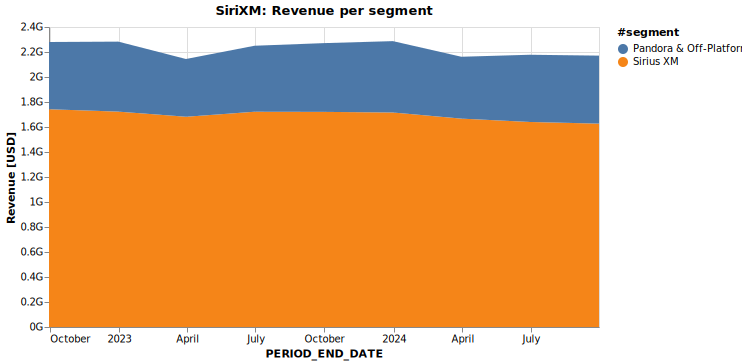

In [147]:
# revenue per segment
query = """
    let(#segment=segment_name();
        #revenue=sales_Rev_turn(fpt=q, fpr=range(2022Q3, 2024Q3));
        )
    get(#segment, #revenue)
    for(segments('SIRI US Equity',type=reported,hierarchy=PRODUCT, level=1))
"""
with BQuery() as bq:
    results = bq.bql(query)
    df = results.combine()
df_wide = df.pivot(index="PERIOD_END_DATE", on="#segment", values="#revenue")
print(df_wide.head(3))

# Chart
alt.Chart(df, title="SiriXM: Revenue per segment").mark_area().encode(
    x=alt.X("PERIOD_END_DATE:T"),
    y=alt.Y("#revenue:Q").axis(format="~s").title("Revenue [USD]"),
    color=alt.Color("#segment:N"),
).properties(width=550)

## 10. Axes
<a id="section-10"></a>

shape: (5, 8)
┌──────────┬────────────────┬─────┬───────────┬───────────┬───────────────┬───────────────┬────────┐
│ ID       ┆ name           ┆ #ax ┆ ASK_DEPTH ┆ BID_DEPTH ┆ ASK_TOTAL_SIZ ┆ BID_TOTAL_SIZ ┆ ticker │
│ ---      ┆ ---            ┆ --- ┆ ---       ┆ ---       ┆ E             ┆ E             ┆ ---    │
│ str      ┆ str            ┆ str ┆ i64       ┆ i64       ┆ ---           ┆ ---           ┆ str    │
│          ┆                ┆     ┆           ┆           ┆ f64           ┆ f64           ┆        │
╞══════════╪════════════════╪═════╪═══════════╪═══════════╪═══════════════╪═══════════════╪════════╡
│ ZL122341 ┆ SWEDA 7 ⅝ PERP ┆ Y   ┆ null      ┆ 6         ┆ null          ┆ 1.54e7        ┆ SWEDA  │
│ Corp     ┆                ┆     ┆           ┆           ┆               ┆               ┆        │
│ BR069680 ┆ SWEDA 4 PERP   ┆ Y   ┆ null      ┆ 1         ┆ null          ┆ 3e6           ┆ SWEDA  │
│ Corp     ┆                ┆     ┆           ┆           ┆               ┆  

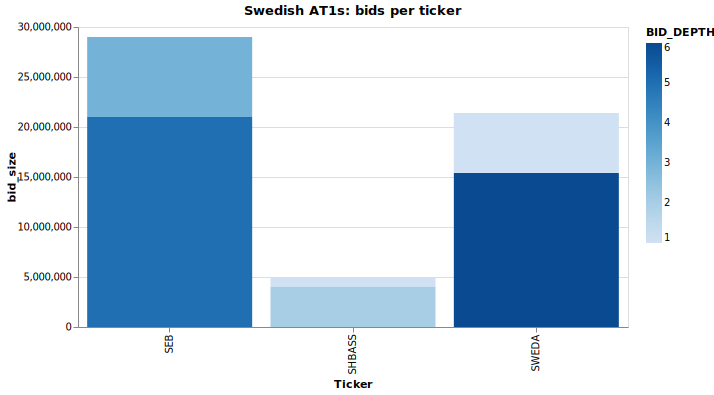

In [148]:
#
# Axes for Swedish AT1 bonds with bids
#
query = """
let(#ax=axes();)
get(name, #ax, ticker)
for(filter(bondsuniv(ACTIVE),
    crncy()=='USD' and
    basel_iii_designation() == 'Additional Tier 1' and
    country_iso() == 'SE' and
    is_axed('Bid') == True))
with(aggregateby=SECURITY)
"""

with BQuery() as bq:
    df = bq.bql(query).combine()
print(df.head())
# Chart
alt.Chart(df, title="Swedish AT1s: bids per ticker").mark_bar().encode(
    x=alt.X("ticker:N").title("Ticker"),
    y=alt.Y("BID_TOTAL_SIZE").title("bid_size"),
    color=alt.Color("BID_DEPTH:Q"),
).properties(width=550)

## 11. Axes with addcol=ALL
<a id="section-11"></a>

shape: (3, 33)
┌─────────────┬────────────┬─────┬───────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ ID          ┆ security_d ┆ #ax ┆ ASK_PRICE ┆ … ┆ amt_outsta ┆ CURRENCY_O ┆ MULTIPLIER ┆ CURRENCY │
│ ---         ┆ es         ┆ --- ┆ ---       ┆   ┆ nding      ┆ F_ISSUE    ┆ ---        ┆ ---      │
│ str         ┆ ---        ┆ str ┆ f64       ┆   ┆ ---        ┆ ---        ┆ f64        ┆ str      │
│             ┆ str        ┆     ┆           ┆   ┆ f64        ┆ str        ┆            ┆          │
╞═════════════╪════════════╪═════╪═══════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ AR506416    ┆ SCOR 5 ¼   ┆ Y   ┆ null      ┆ … ┆ 7.498e8    ┆ USD        ┆ 1.0        ┆ USD      │
│ Corp        ┆ PERP       ┆     ┆           ┆   ┆            ┆            ┆            ┆          │
│ BM367786    ┆ ALVGR 3 ½  ┆ Y   ┆ 96.625    ┆ … ┆ 1.2500e9   ┆ USD        ┆ 1.0        ┆ USD      │
│ Corp        ┆ PERP       ┆     ┆           ┆   ┆            ┆            ┆

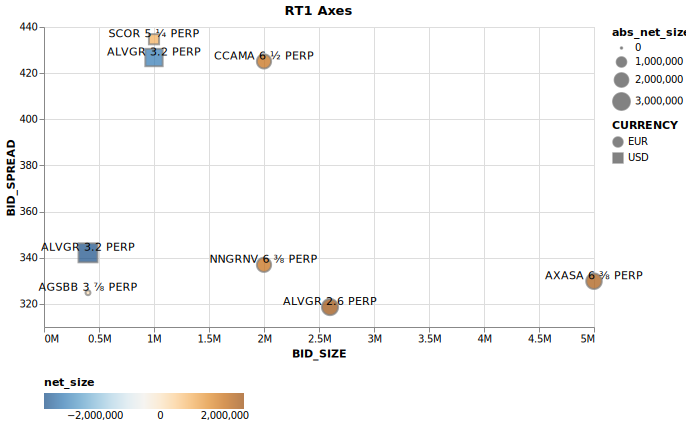

In [149]:
#
# RT1 Axes with all columns
#
query = """
let(#ax=axes(aggregateby='SECURITY');)
get(security_des, #ax, amt_outstanding)
for(filter(axedUniv('all'),
    crncy() in ['USD', 'EUR'] and
    solvency_ii_designation() == 'Restricted Tier 1' and
    amt_outstanding() > 500e6))
preferences(addcols=all)
"""

with BQuery() as bq:
    df = bq.bql(query).combine()
print(df.head(3))

# Chart
g_data = (
    df.with_columns(
        pl.col("BID_SIZE").fill_null(0),
        pl.col("ASK_SIZE").fill_null(0),
        (pl.col("BID_SIZE").fill_null(0) - pl.col("ASK_SIZE").fill_null(0)).alias(
            "net_size"
        ),
    )
    .with_columns(pl.col("net_size").abs().alias("abs_net_size"))
    .filter(pl.col("BID_SPREAD") > 110)  # noqa: PLR2004
)
base = alt.Chart(g_data, title="RT1 Axes").encode(
    x=alt.X("BID_SIZE:Q").axis(format="~s"),
    y=alt.Y("BID_SPREAD:Q").scale(zero=False),
)
points = base.mark_point(stroke="grey", filled=True).encode(
    color=alt.Color("net_size:Q").scale(scheme="blueorange").legend(orient="bottom"),
    detail=alt.Detail("security_des:N"),
    shape=alt.Shape("CURRENCY"),
    size=alt.Size("abs_net_size:Q"),
)
txt = base.mark_text(align="center", baseline="bottom").encode(text="security_des:N")
(points + txt).properties(width=550)

## 12. Bonds from Equity Ticker
<a id="section-12"></a>

In [150]:
# Get Bond Universe from Equity Ticker
query = """
let(#rank=normalized_payment_rank();
    #oas=spread(st=oas);
    #nxt_call=nxt_call_dt();
    )
get(name(), #rank, #nxt_call, #oas)
for(filter(bonds('GTN US Equity'), series() == '144A'))
"""

with BQuery() as bq:
    df = bq.bql(query).combine()
print(df)

shape: (5, 6)
┌───────────────┬───────────────────┬──────────────────┬────────────┬─────────────┬────────────┐
│ ID            ┆ name()            ┆ #rank            ┆ #nxt_call  ┆ #oas        ┆ DATE       │
│ ---           ┆ ---               ┆ ---              ┆ ---        ┆ ---         ┆ ---        │
│ str           ┆ str               ┆ str              ┆ date       ┆ f64         ┆ date       │
╞═══════════════╪═══════════════════╪══════════════════╪════════════╪═════════════╪════════════╡
│ BS116983 Corp ┆ GTN 5 ⅜ 11/15/31  ┆ Sr Unsecured     ┆ 2026-11-15 ┆ 1274.500312 ┆ 2024-12-20 │
│ YX231113 Corp ┆ GTN 10 ½ 07/15/29 ┆ 1st Lien Secured ┆ 2026-07-15 ┆ 607.418863  ┆ 2024-12-20 │
│ ZO860846 Corp ┆ GTN 4 ¾ 10/15/30  ┆ Sr Unsecured     ┆ 2025-10-15 ┆ 1350.617215 ┆ 2024-12-20 │
│ AV438089 Corp ┆ GTN 7 05/15/27    ┆ Sr Unsecured     ┆ 2024-12-29 ┆ 447.470531  ┆ 2024-12-20 │
│ LW375188 Corp ┆ GTN 5 ⅞ 07/15/26  ┆ Sr Unsecured     ┆ 2025-01-18 ┆ 168.602434  ┆ 2024-12-20 │
└───────────────

## 13. Bond Total Return
<a id="section-13"></a>
After retrieving the total return series, we convert the result into a wide format so that each bond appears in a separate column. This is done by using the bond IDs for the column labels, the dates for the index, and the return values as entries in the pivot table:

shape: (3, 6)
┌────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ DATE       ┆ BS116983 Corp ┆ YX231113 Corp ┆ ZO860846 Corp ┆ AV438089 Corp ┆ LW375188 Corp │
│ ---        ┆ ---           ┆ ---           ┆ ---           ┆ ---           ┆ ---           │
│ date       ┆ f64           ┆ f64           ┆ f64           ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 2024-12-06 ┆ 0.016153      ┆ -0.000041     ┆ 0.024995      ┆ 0.000766      ┆ 0.000937      │
│ 2024-12-13 ┆ -0.047024     ┆ 0.001495      ┆ -0.043528     ┆ -0.000233     ┆ 0.002241      │
│ 2024-12-20 ┆ -0.046302     ┆ -0.009142     ┆ -0.061639     ┆ -0.011733     ┆ 0.000409      │
└────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘


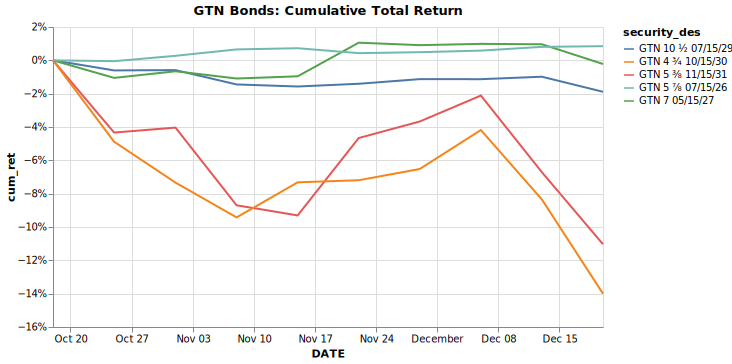

In [151]:
# Weekly Total Return of GTN Bonds
query = """
let(#rng = range(-3M, 0D);
    #rets = return_series(calc_interval=#rng,per=W);)
get(#rets, security_des)
for(filter(bonds('GTN US Equity'), series() == '144A'))
"""

with BQuery() as bq:
    df = bq.bql(query).combine()
    df_wide = df.pivot(on="ID", index="DATE", values="#rets")
print(df_wide.tail(3))

# Chart
g_data = df.with_columns(
    pl.col("#rets").fill_null(0).add(1).cum_prod().add(-1).over("ID").alias("cum_ret")
)
alt.Chart(g_data, title="GTN Bonds: Cumulative Total Return").mark_line().encode(
    x=alt.X("DATE:T"),
    y=alt.Y("cum_ret:Q").axis(format="%"),
    color=alt.Color("security_des:N"),
).properties(width=550)